<a href="https://colab.research.google.com/github/Ayanlola2002/Data-Science-Nigeria/blob/master/developing_Staff_promotion_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [578]:
!kaggle competitions download -c intercampusai2019

sample_submission2.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#unzippig the us-data file
from shutil import unpack_archive
#unpack_archive('all.zip')
unpack_archive('train.csv.zip')
unpack_archive('test.csv.zip')

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [0]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [0]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [0]:
#train = pd.read_csv('train.csv',parse_dates=[['weblog_date'],['date_of_advert'],['last_advert_online']])
#test = pd.read_csv('test.csv',parse_dates=[weblog_date],[[date_of_advert],[last_advert_online])
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
sample=pd.read_csv('sample_submission2.csv')

In [586]:
sample.head()

,EmployeeNo,Promoted_or_Not
0,YAK/S/34385,1
1,YAK/S/27825,1
2,YAK/S/23870,1
3,YAK/S/54784,1
4,YAK/S/25058,1


In [0]:
train_copy=train.copy()
test_copy=test.copy()

In [588]:
##display the first five rows of the train dataset.
train.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [589]:
##display the first five rows of the test dataset.
test.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,YAK/S/00005,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1976,7.500,2017,0,0,65,FCT,Yes,Married,No,No,1
1,YAK/S/00011,Information Technology and Solution Support,NaN,Male,Direct Internal process,2,1991,0.000,2018,0,0,69,OGUN,Yes,Married,No,No,1
2,YAK/S/00015,Research and Innovation,"MSc, MBA and PhD",Male,Direct Internal process,2,1984,7.500,2012,0,0,76,KANO,Yes,Married,No,No,1
3,YAK/S/00016,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1984,2.500,2009,0,0,52,RIVERS,No,Single,No,No,1
4,YAK/S/00017,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1983,7.500,2014,1,0,69,FCT,Yes,Married,No,No,0


In [590]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (38312, 19) 
The test data size before dropping Id feature is : (16496, 18) 


In [0]:
#Save the 'Id' column
train_ID = train['EmployeeNo']
test_ID = test['EmployeeNo']

In [0]:
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("EmployeeNo", axis = 1, inplace = True)
test.drop("EmployeeNo", axis = 1, inplace = True)

In [0]:
#save and drop the target varriable
y_train=train['Promoted_or_Not']

In [0]:
#dropping the target varriable
train.drop('Promoted_or_Not',axis=1,inplace=True)

In [595]:
train.dtypes

Division                                object
Qualification                           object
Gender                                  object
Channel_of_Recruitment                  object
Trainings_Attended                       int64
Year_of_birth                            int64
Last_performance_score                 float64
Year_of_recruitment                      int64
Targets_met                              int64
Previous_Award                           int64
Training_score_average                   int64
State_Of_Origin                         object
Foreign_schooled                        object
Marital_Status                          object
Past_Disciplinary_Action                object
Previous_IntraDepartmental_Movement     object
No_of_previous_employers                object
dtype: object

In [0]:
#separate categorical varriable from numerical varriable
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
#quantitative.remove('SalePrice')
#quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [597]:
quantitative

['Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average']

In [598]:
qualitative

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

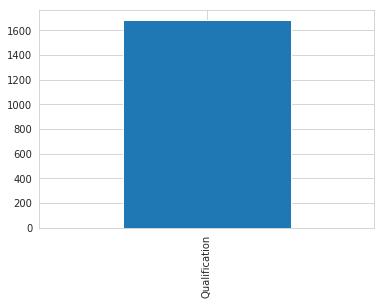

In [599]:
#missing values
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [600]:
# check number & percentage of missing value in the columns
def missing_values_table(df):
  mis_val = df.isnull().sum() #total missing values
  mis_val_percent = 100 * df.isnull().sum() / len(df) #percentage of missing values
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) #make a table with the results
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename the columns
     # sort the table by percentage of missing value
  mis_val_table_ren_columns = mis_val_table_ren_columns[
  mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        #print same summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

          # return the dataframe with missing information
  return mis_val_table_ren_columns
  
missing_values = missing_values_table(train)
missing_values.head()

Your selected dataframe has 17 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Qualification,1679,4.400


In [0]:
cols_with_missing = [col for col in train.columns if train[col].isnull().any()]

reduced_train =train.drop(cols_with_missing, axis=1)
reduced_test = test.drop(cols_with_missing, axis=1)

In [602]:
#Handling missing values
train['Qualification'].unique()

array(['MSc, MBA and PhD', 'First Degree or HND', nan,
       'Non-University Education'], dtype=object)

In [0]:
train['Qualification'].fillna('NA',inplace=True)
test['Qualification'].fillna('NA',inplace=True)

In [604]:
'''def ConvertQualificationToFeature(desc):
  Qualification={
      'MSc, MBA and PhD':5,
      'First Degree or HND':3,
      'Non-University Education':1,
      'NA':0
      }
  return Qualification[desc]'''

"def ConvertQualificationToFeature(desc):\n  Qualification={\n      'MSc, MBA and PhD':5,\n      'First Degree or HND':3,\n      'Non-University Education':1,\n      'NA':0\n      }\n  return Qualification[desc]"

In [0]:
#train['Qualification']=train['Qualification'].apply(ConvertQualificationToFeature)
#test['Qualification']=test['Qualification'].apply(ConvertQualificationToFeature)

In [606]:
train.head(50)
#qualification done

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0
1,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0
2,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0
3,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1
4,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1
5,Customer Support and Field Operations,First Degree or HND,Female,Agency and others,2,1990,7.500,2014,0,0,51,ENUGU,Yes,Married,No,Yes,1
6,Customer Support and Field Operations,"MSc, MBA and PhD",Male,Direct Internal process,2,1988,7.500,2013,0,0,55,OYO,No,Single,No,No,1
7,Information and Strategy,First Degree or HND,Male,Agency and others,2,1993,10.000,2014,0,0,75,LAGOS,Yes,Married,No,No,0
8,Commercial Sales and Marketing,"MSc, MBA and PhD",Male,Direct Internal process,2,1989,12.500,2014,1,0,46,ONDO,Yes,Married,No,No,0
9,Commercial Sales and Marketing,First Degree or HND,Female,Direct Internal process,2,1986,12.500,2016,1,0,42,LAGOS,Yes,Married,No,No,0


In [607]:
train['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [608]:
#one hot encode gender since it does not show hirarchy male cant be said to be more importance than female
train['Gender'].value_counts()

Male      26880
Female    11432
Name: Gender, dtype: int64

In [609]:
#one hot encode
train['Division'].value_counts()

Commercial Sales and Marketing                 11695
Customer Support and Field Operations           7973
Sourcing and Purchasing                         5052
Information Technology and Solution Support     4952
Information and Strategy                        3721
Business Finance Operations                     1786
People/HR Management                            1704
Regulatory and Legal services                    733
Research and Innovation                          696
Name: Division, dtype: int64

In [610]:
train['Division'].unique()

array(['Commercial Sales and Marketing',
       'Customer Support and Field Operations',
       'Information and Strategy',
       'Information Technology and Solution Support',
       'Sourcing and Purchasing', 'Business Finance Operations',
       'People/HR Management', 'Research and Innovation',
       'Regulatory and Legal services'], dtype=object)

In [0]:
def ConvertDivisionToFeature(desc):
  Division={
      'Commercial Sales and Marketing':'CSM',
      'Customer Support and Field Operations':'CSFO',
      'Information and Strategy':'IS',
      'Information Technology and Solution Support':'ITSS',
      'Sourcing and Purchasing':'SP',
      'Business Finance Operations':'BFO',
      'People/HR Management':'PHM',
      'Research and Innovation':'RI',
      'Regulatory and Legal services':'RLS'
      }
  return Division[desc]

In [0]:
train['Division']=train['Division'].apply(ConvertDivisionToFeature)
test['Division']=test['Division'].apply(ConvertDivisionToFeature)

In [613]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,CSM,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0
1,CSFO,First Degree or HND,Male,Agency and others,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0
2,CSM,First Degree or HND,Male,Direct Internal process,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0
3,CSM,First Degree or HND,Male,Agency and others,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1
4,IS,First Degree or HND,Male,Direct Internal process,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1


In [614]:
#one encode
train['Channel_of_Recruitment'].value_counts()

Agency and others                  21310
Direct Internal process            16194
Referral and Special candidates      808
Name: Channel_of_Recruitment, dtype: int64

In [615]:
train['Channel_of_Recruitment'].unique()

array(['Direct Internal process', 'Agency and others',
       'Referral and Special candidates'], dtype=object)

In [0]:
def convertChannelToFeature(desc):
  Channel={
      'Direct Internal process':'DIP',
      'Agency and others':'AO',
      'Referral and Special candidates':'RSC'
      }
  return Channel[desc]

In [0]:
train['Channel_of_Recruitment']=train['Channel_of_Recruitment'].apply(convertChannelToFeature)
test['Channel_of_Recruitment']=test['Channel_of_Recruitment'].apply(convertChannelToFeature)

In [618]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1


In [619]:
qualitative

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [620]:
train['State_Of_Origin'].value_counts()

LAGOS          6204
FCT            2389
OGUN           2302
RIVERS         2222
ANAMBRA        1710
KANO           1649
DELTA          1594
OYO            1508
KADUNA         1399
IMO            1307
EDO            1259
ENUGU          1025
ABIA            950
OSUN            929
ONDO            875
NIGER           857
KWARA           765
PLATEAU         739
AKWA IBOM       673
NASSARAWA       632
KATSINA         615
ADAMAWA         605
BENUE           579
BAUCHI          557
KOGI            542
SOKOTO          499
CROSS RIVER     495
EKITI           455
BORNO           447
TARABA          400
KEBBI           393
BAYELSA         324
EBONYI          313
GOMBE           291
ZAMFARA         290
JIGAWA          262
YOBE            257
Name: State_Of_Origin, dtype: int64

In [0]:
#categorized into six geo-political zones
def ConvertToGeoPoliticalZone(desc):
  
  State={
      
      'BENUE':'NC',
      'KOGI':'NC',
      'KWARA':'NC',
      'NASSARAWA':'NC',
      'NIGER':'NC',
      'PLATEAU':'NC',
      'FCT':'NC',
      
      'ADAMAWA':'NE',
      'BAUCHI':'NE',
      'BORNO':'NE',
      'GOMBE':'NE',
      'TARABA':'NE',
      'YOBE':'NE',
      
      
          
      'JIGAWA':'NW',
      'KADUNA':'NW',
      'KANO':'NW',
      'KATSINA':'NW',
      'KEBBI':'NW',
      'SOKOTO':'NW',
      'ZAMFARA':'NW',
      
          
      'ABIA':'SE',
      'ANAMBRA':'SE',
      'EBONYI':'SE',
      'ENUGU':'SE',
      'IMO':'SE',
      
      'AKWA IBOM':'SS',
      'BAYELSA':'SS',
      'CROSS RIVER':'SS',
      'RIVERS':'SS',
      'DELTA':'SS',
      'EDO':'SS',
     
        
      'EKITI':'SW',
      'LAGOS':'SW',
      'OGUN':'SW',
      'ONDO':'SW',
      'OSUN':'SW',
      'OYO':'SW'
      }
  return State[desc]

In [0]:
#one hot encode
train['State_Of_Origin']=train['State_Of_Origin'].apply(ConvertToGeoPoliticalZone)
test['State_Of_Origin']=test['State_Of_Origin'].apply(ConvertToGeoPoliticalZone)

In [623]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1


In [624]:
#hirarchy coding 2,1 
#one hot encode first later perform hirarchical encoding
train['Foreign_schooled'].value_counts()

Yes    34995
No      3317
Name: Foreign_schooled, dtype: int64

In [0]:
#we could add hirarchical feature of people that foreigned schooled and PHD:4,with First degree :3,Local(PHD):3,Local Bsc:2,uneducated:1,noinfo:1 

In [626]:
#one ehot encode
train['Marital_Status'].value_counts()

Married     31022
Single       6927
Not_Sure      363
Name: Marital_Status, dtype: int64

In [627]:
#Do Hirarchical encoding NO:1  ,yes :0
train['Past_Disciplinary_Action'].value_counts()

No     38161
Yes      151
Name: Past_Disciplinary_Action, dtype: int64

In [628]:
'''def ConvertDisciplinaryToFeature(desc):
  DisciplinaryAction={
      'Yes':0,
      'No':1
      
  }
  return DisciplinaryAction[desc]'''

"def ConvertDisciplinaryToFeature(desc):\n  DisciplinaryAction={\n      'Yes':0,\n      'No':1\n      \n  }\n  return DisciplinaryAction[desc]"

In [0]:
#it is logical to rate those without dicsciplinary action higher than those that have
#train['Past_Disciplinary_Action']=train['Past_Disciplinary_Action'].apply(ConvertDisciplinaryToFeature)
#test['Past_Disciplinary_Action']=test['Past_Disciplinary_Action'].apply(ConvertDisciplinaryToFeature)

In [630]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1


In [631]:
'''def Previous_IntraDepartmental_Movement(desc):
  Movement={
      'Yes':1,
      'No':0
      
  }
  return Movement[desc]'''

"def Previous_IntraDepartmental_Movement(desc):\n  Movement={\n      'Yes':1,\n      'No':0\n      \n  }\n  return Movement[desc]"

In [632]:

#You might want to try rating those with more intra deptmental movement high cos looks like they might understand the flow of the business more
#will try one hot encoding first
train['Previous_IntraDepartmental_Movement'].value_counts()

No     34709
Yes     3603
Name: Previous_IntraDepartmental_Movement, dtype: int64

In [0]:
#train['Previous_IntraDepartmental_Movement']=train['Previous_IntraDepartmental_Movement'].apply(Previous_IntraDepartmental_Movement)
#test['Previous_IntraDepartmental_Movement']=test['Previous_IntraDepartmental_Movement'].apply(Previous_IntraDepartmental_Movement)

In [634]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1


In [635]:
'''def ConvertNumberOfPreviousEmployerFeature(desc):
  Past={
      '0':0,
      '1':1,
      '2':2,
      '3':3,
      '4':4,
      '5':5,
      'More than 5':7
      }
  return Past[desc]'''

"def ConvertNumberOfPreviousEmployerFeature(desc):\n  Past={\n      '0':0,\n      '1':1,\n      '2':2,\n      '3':3,\n      '4':4,\n      '5':5,\n      'More than 5':7\n      }\n  return Past[desc]"

In [636]:

train['No_of_previous_employers'].value_counts()

1              18867
0              13272
2               1918
3               1587
4               1324
5                943
More than 5      401
Name: No_of_previous_employers, dtype: int64

In [637]:
train['No_of_previous_employers'].unique()

array(['0', '1', '4', '3', '2', 'More than 5', '5'], dtype=object)

In [0]:
#train['No_of_previous_employers']=train['No_of_previous_employers'].apply(ConvertNumberOfPreviousEmployerFeature)
#test['No_of_previous_employers']=test['No_of_previous_employers'].apply(ConvertNumberOfPreviousEmployerFeature)

In [639]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1


In [640]:
#no of years spent in establishment can be calculated
train['Year_of_recruitment'].value_counts()

2016    4916
2015    4757
2017    4656
2014    4101
2012    3909
2013    3314
2018    3194
2011    2011
2010    1865
2009    1497
2008     619
2007     570
2006     472
2004     422
2003     394
2005     376
2002     293
2001     269
2000     230
1999      90
1998      53
1995      51
1996      46
1997      38
1994      35
1993      27
1990      22
1991      21
1992      20
1988      13
1989      11
1987       8
1986       7
1985       4
1982       1
Name: Year_of_recruitment, dtype: int64

In [641]:
#age feature could be added
train['Year_of_birth'].value_counts()

1991    2544
1990    2506
1989    2441
1992    2380
1988    2268
1993    2217
1987    2157
1994    1985
1986    1882
1985    1766
1984    1505
1995    1416
1983    1342
1982    1195
1981    1162
1996     910
1980     893
1979     797
1978     685
1977     600
1997     596
1976     551
1975     508
1973     397
1974     394
1971     353
1972     312
1998     305
1970     256
1969     249
1968     233
1966     207
1967     195
1965     178
1964     168
1999     167
1963     161
1961     147
1962     134
2001      71
2000      66
1957       4
1958       3
1960       1
1959       1
1956       1
1955       1
1950       1
1952       1
Name: Year_of_birth, dtype: int64

In [0]:
from datetime import date
def CalculateYear(year):
  today=date.today()
  age=today.year-year
  return age


In [0]:
train['No_Of_Year_Spent']=train['Year_of_recruitment'].apply(CalculateYear)
test['No_Of_Year_Spent']=test['Year_of_recruitment'].apply(CalculateYear)

In [0]:
train['Age_in_years']=train['Year_of_birth'].apply(CalculateYear)
test['Age_in_years']=test['Year_of_birth'].apply(CalculateYear)

In [645]:
train.head()


,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,No_Of_Year_Spent,Age_in_years
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,8,33
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4,28
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,7,32
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,10,37
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,7,29


In [0]:
#dropping Year_of_recruitment and Year_of_birth
train.drop('Year_of_recruitment', axis = 1, inplace = True)
test.drop('Year_of_recruitment', axis = 1, inplace = True)

train.drop('Year_of_birth', axis = 1, inplace = True)
test.drop('Year_of_birth', axis = 1, inplace = True)


In [647]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,No_Of_Year_Spent,Age_in_years
0,CSM,"MSc, MBA and PhD",Female,DIP,2,12.500,1,0,41,SE,No,Married,No,No,0,8,33
1,CSFO,First Degree or HND,Male,AO,2,12.500,0,0,52,SE,Yes,Married,No,No,0,4,28
2,CSM,First Degree or HND,Male,DIP,2,7.500,0,0,42,NW,Yes,Married,No,No,0,7,32
3,CSM,First Degree or HND,Male,AO,3,2.500,0,0,42,NC,Yes,Single,No,No,1,10,37
4,IS,First Degree or HND,Male,DIP,3,7.500,0,0,77,SS,Yes,Married,No,No,1,7,29


In [648]:
train.dtypes

Division                                object
Qualification                           object
Gender                                  object
Channel_of_Recruitment                  object
Trainings_Attended                       int64
Last_performance_score                 float64
Targets_met                              int64
Previous_Award                           int64
Training_score_average                   int64
State_Of_Origin                         object
Foreign_schooled                        object
Marital_Status                          object
Past_Disciplinary_Action                object
Previous_IntraDepartmental_Movement     object
No_of_previous_employers                object
No_Of_Year_Spent                         int64
Age_in_years                             int64
dtype: object

In [649]:
'''0 Division                                object
1 Qualification                           int64
2 Gender                                  object
3 Channel_of_Recruitment                  object
4 Trainings_Attended     *                  int64
5 Last_performance_score *               float64
6 Targets_met     *                         int64
7 Previous_Award    *                       int64
8 Training_score_average  *                 int64
9 State_Of_Origin                         object
10 Foreign_schooled                        object
11 Marital_Status                          object
12 Past_Disciplinary_Action                 int64
13 Previous_IntraDepartmental_Movement      int64
14 No_of_previous_employers                 int64
15 No_Of_Year_Spent  *                       int64
16 Age_in_years  *'''

'0 Division                                object\n1 Qualification                           int64\n2 Gender                                  object\n3 Channel_of_Recruitment                  object\n4 Trainings_Attended     *                  int64\n5 Last_performance_score *               float64\n6 Targets_met     *                         int64\n7 Previous_Award    *                       int64\n8 Training_score_average  *                 int64\n9 State_Of_Origin                         object\n10 Foreign_schooled                        object\n11 Marital_Status                          object\n12 Past_Disciplinary_Action                 int64\n13 Previous_IntraDepartmental_Movement      int64\n14 No_of_previous_employers                 int64\n15 No_Of_Year_Spent  *                       int64\n16 Age_in_years  *'

In [650]:
['Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average']

['Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average']

In [651]:
qualitative

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [0]:
#extracting the index of categorical varriable
categorical_var = np.where((train.dtypes != np.float)&(train.dtypes != np.int))[0]
#train.dtypes[f] != 'object']

In [653]:
categorical_var

array([ 0,  1,  2,  3,  9, 10, 11, 12, 13, 14])

In [0]:
#one hot encode categorical varribles

for column in qualitative:
    dummies = pd.get_dummies(train[column], prefix=column[:5])
    train = pd.concat([train, dummies], axis=1)

for column in qualitative:
    dummies = pd.get_dummies(test[column], prefix=column[:5])
    test = pd.concat([test, dummies], axis=1)

In [0]:
#drop all categorical column
train.drop(qualitative,axis=1,inplace=True)

In [0]:
test.drop(qualitative,axis=1,inplace=True)

In [0]:
# train and valid sets from train
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split

#x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)

In [0]:
#model_RF=RandomForestClassifier(n_estimators=200,random_state=200,max_features=0.5,min_samples_leaf=3,oob_score=True,n_jobs=-1)
#model_RF.fit(train,y_train)

In [0]:
#Our Score on Validation Data
#model_RF.score(x_valid,y_valid)

In [0]:
#Prediction on Test Set
#predict_y_RF = model_RF.predict(test)

In [0]:
#Our Score on Training data
#model.score(x_trn,y_trn)

In [0]:
#Prepare our Submission file
#my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_RF })
#my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
#!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

In [0]:
#!kaggle competitions submissions -c intercampusai2019

In [0]:
#Applying ADABoost
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.model_selection import train_test_split

#x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)

In [0]:
#model_ada = AdaBoostClassifier()
#model_ada.fit(train,y_train)

In [0]:
#Our Score on Validation Data
#model_ada.score(x_valid,y_valid)

In [0]:
#Prediction on Test Set
#predict_y_ada = model_ada.predict(test)

In [0]:
#Our Score on Training data
#model_ada.score(x_trn,y_trn)

In [0]:
#Prepare our Submission file
#my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_ada })
#my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
#!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

In [0]:
#!kaggle competitions submissions -c intercampusai2019

In [0]:
#Applying XGBOOST
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)

In [658]:
#Applying XGboost
model_xg =XGBClassifier(objective="binary:logistic", 
    learning_rate=0.05, 
    seed=9616, 
    max_depth=20, 
    gamma=10, 
    n_estimators=500)
model_xg.fit(train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=10,
              learning_rate=0.05, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=9616,
              silent=None, subsample=1, verbosity=1)

In [659]:
'''model_xg =XGBClassifier(n_estimators=30,learning_rate =0.3,max_depth=3,
                        min_child_weight=1,gamma=0.3,subsample=0.8,colsample_bytree=0.8,
                        objective= 'binary:logistic',nthread=4,scale_pos_weight=1,reg_alpha=1e-05,
                        reg_lambda=1,seed=27)

model_xg.fit(train,y_train)'''

"model_xg =XGBClassifier(n_estimators=30,learning_rate =0.3,max_depth=3,\n                        min_child_weight=1,gamma=0.3,subsample=0.8,colsample_bytree=0.8,\n                        objective= 'binary:logistic',nthread=4,scale_pos_weight=1,reg_alpha=1e-05,\n                        reg_lambda=1,seed=27)\n\nmodel_xg.fit(train,y_train)"

In [660]:
#Our Score on Validation Data
model_xg.score(x_valid,y_valid)

0.9475401278872504

In [0]:
#Prediction on Test Set
predict_y_xg = model_xg.predict(test)

In [662]:
#Our Score on Training data
model_xg.score(x_trn,y_trn)

0.9419556918659663

In [0]:
#Prepare our Submission file
my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_xg })
my_submission.to_csv('submission_ayanlola.csv', index=False)

In [664]:
!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

100% 226k/226k [00:04<00:00, 48.8kB/s]
Successfully submitted to Data Science Nigeria Staff Promotion Algorithm 

In [665]:
!kaggle competitions submissions -c intercampusai2019

fileName                 date                 description  status    publicScore  privateScore  
-----------------------  -------------------  -----------  --------  -----------  ------------  
submission_ayanlola.csv  2019-10-15 23:27:06  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-15 23:12:32  BOOTCAMP     complete  0.94159      None          
submission_ayanlola.csv  2019-10-15 15:23:23  BOOTCAMP     complete  0.94058      None          
submission_ayanlola.csv  2019-10-15 05:36:14  BOOTCAMP     complete  0.94139      None          
submission_ayanlola.csv  2019-10-15 05:11:08  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-15 02:58:16  BOOTCAMP     complete  0.94159      None          
submission_ayanlola.csv  2019-10-14 14:30:05  BOOTCAMP     complete  0.94361      None          
submission_ayanlola.csv  2019-10-13 23:11:24  BOOTCAMP     complete  0.94421      None          
submission_ayanlola.csv  2019-

In [0]:
#Applying light boost classifier
#from lightgbm import LGBMClassifier
#from sklearn.model_selection import train_test_split

#x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)











In [0]:

#model_lgb =LGBMClassifier(n_estimators=400,num_leaves=100,verbosity=0)
#model_lgb.fit(train,y_train)

In [0]:
#Our Score on Validation Data
#model_lgb.score(x_valid,y_valid)

In [0]:
#Prediction on Test Set
#predict_y_lgb = model_lgb.predict(test)

In [0]:

#Our Score on Training data
#model_lgb.score(x_trn,y_trn)

In [0]:
#Prepare our Submission file
#my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_lgb })
#my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
#!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

In [0]:
#!kaggle competitions submissions -c intercampusai2019

In [564]:
#!pip install catboost

In [0]:
#applying catboost
#from catboost import CatBoostRegressor, CatBoostClassifier
#from sklearn.model_selection import train_test_split

x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)


In [0]:
#categorical_var = np.where(train_x.dtypes != np.float)[0]

In [567]:
model_cat = CatBoostClassifier(iterations = 10000,
                                task_type = 'GPU',
                                eval_metric='AUC',
                                loss_function= 'Logloss',
                                cat_features=[1,2,3,4,10,11,12,13,14,15],
                                #learning_rate=0.003
                                scale_pos_weight = 1.55,
                                #depth=7
                                )

model_cat.fit(train,y_train)

CatBoostError: ignored

In [0]:
#Our Score on Validation Data
model_cat.score(x_valid,y_valid)

In [0]:
#Prediction on Test Set
predict_y_cat = model_cat.predict(test)

In [0]:
#Our Score on Training data
model_cat.score(x_trn,y_trn)

In [0]:
#Prepare our Submission file
my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_cat })
my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

In [0]:
!kaggle competitions submissions -c intercampusai2019